In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras_facenet import FaceNet
from scipy.spatial.distance import cosine
import dlib
from imutils import face_utils
from tensorflow.keras import backend as K
import kerastuner as kt
from kerastuner.tuners import BayesianOptimization
from typing import List, Tuple, Dict
import os
from PIL import Image
import numpy as np
from tqdm import tqdm
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Input

d:\Anaconda\Anaconda\envs\jear\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.4 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "
C:\Users\PC\AppData\Local\Temp\ipykernel_17420\3932289071.py:15: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [2]:
from typing import Tuple
import os
from PIL import Image
import numpy as np
from tqdm import tqdm
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

def prepare_dataset(
    dataset_dir: str,
    resize: int = 224,
    val_split: float = 0.2
) -> Tuple[np.array, np.array, np.array, np.array]:
    labels = []
    images = []
    val_labels = []  # Initialize validation labels
    val_images = []  # Initialize validation images
    class_names = os.listdir(dataset_dir)
    
    # Map class names to IDs
    classes_map = {classname: idx for idx, classname in enumerate(class_names)}
    
    # Dictionary to track image counts per class
    class_image_count = {classname: 0 for classname in class_names}
    
    for classname in tqdm(class_names):
        class_id = classes_map[classname]
        image_dir = os.path.join(dataset_dir, classname)
        
        # Check if the image_dir exists and is a directory
        if not os.path.isdir(image_dir):
            print(f"Warning: {image_dir} is not a valid directory. Skipping.")
            continue
        
        # Gather all images in this class
        class_images = []
        for image_filename in os.listdir(image_dir):
            image_path = os.path.join(image_dir, image_filename)
            try:
                image = Image.open(image_path)
                image = image.resize((resize, resize))
                image = np.array(image)
                image = image.astype(float)
                image = preprocess_input(image)
                class_images.append((image, class_id))
                class_image_count[classname] += 1  # Increment the count for this class
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")

        # Split into train and validation sets
        split_index = int(len(class_images) * (1 - val_split))
        for img, lbl in class_images[:split_index]:
            images.append(img)
            labels.append(lbl)
        for img, lbl in class_images[split_index:]:
            val_images.append(img)
            val_labels.append(lbl)

    # Print summary of class image counts
    for classname, count in class_image_count.items():
        print(f"Class '{classname}': {count} images read.")

    return np.array(images), np.array(labels), np.array(val_images), np.array(val_labels)

# Assuming 'dataset_dir' is set to your Original_Images path
dataset_dir = 'D:/DS_project/Jear_project/Original_Images/Original_Images'
train_x, train_y, val_x, val_y = prepare_dataset(dataset_dir, resize=224)


100%|██████████| 31/31 [00:57<00:00,  1.86s/it]


Class 'Akshay Kumar': 50 images read.
Class 'Alexandra Daddario': 92 images read.
Class 'Alia Bhatt': 79 images read.
Class 'Amitabh Bachchan': 74 images read.
Class 'Andy Samberg': 92 images read.
Class 'Anushka Sharma': 68 images read.
Class 'Billie Eilish': 98 images read.
Class 'Brad Pitt': 120 images read.
Class 'Camila Cabello': 87 images read.
Class 'Charlize Theron': 78 images read.
Class 'Claire Holt': 96 images read.
Class 'Courtney Cox': 80 images read.
Class 'Dwayne Johnson': 61 images read.
Class 'Elizabeth Olsen': 71 images read.
Class 'Ellen Degeneres': 75 images read.
Class 'Henry Cavill': 106 images read.
Class 'Hrithik Roshan': 101 images read.
Class 'Hugh Jackman': 112 images read.
Class 'Jessica Alba': 108 images read.
Class 'Kashyap': 30 images read.
Class 'Lisa Kudrow': 70 images read.
Class 'Margot Robbie': 72 images read.
Class 'Marmik': 32 images read.
Class 'Natalie Portman': 105 images read.
Class 'Priyanka Chopra': 102 images read.
Class 'Robert Downey Jr': 

In [69]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input
from tensorflow.keras.models import Model
from typing import Dict, Tuple

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)


    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a - p), axis=-1)
        n_dist = K.sum(K.square(a - n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)


    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "alpha": self.alpha,
        })
        return config
def get_triplets(labels: np.array, map_label_indices: Dict[int, np.array]) -> Tuple[int, int, int]:
    unique_label = np.unique(labels)
    label_l, label_r = np.random.choice(unique_label, 2, replace=False)
    a, p = np.random.choice(map_label_indices[label_l], 2, replace=False)
    n = np.random.choice(map_label_indices[label_r])
    return a, p, n

def get_triplets(
    labels: np.array,
    map_label_indices: Dict[int, np.array]
) -> Tuple[int, int, int]:
    unique_label = np.unique(labels)
    label_l, label_r = np.random.choice(unique_label, 2, replace=False)
    a, p = np.random.choice(map_label_indices[label_l], 2, replace=False)
    n = np.random.choice(map_label_indices[label_r])
    return a, p, n


def get_triplets_batch(
    data_batch: int,
    images: np.array,
    labels: np.array,
    map_label_indices: Dict[int, np.array]
) -> Tuple[List[tf.Tensor], List]:
    while True:
        idxs_a, idxs_p, idxs_n = [], [], []
        for _ in range(data_batch):
            a, p, n = get_triplets(labels=labels, map_label_indices=map_label_indices)
            idxs_a.append(a)
            idxs_p.append(p)
            idxs_n.append(n)

        a = [images[i] for i in idxs_a]
        p = [images[i] for i in idxs_p]
        n = [images[i] for i in idxs_n]

        a = tf.convert_to_tensor(a, dtype=tf.float32)
        p = tf.convert_to_tensor(p, dtype=tf.float32)
        n = tf.convert_to_tensor(n, dtype=tf.float32)

        yield [a, p, n], []


def get_map_indices(labels: np.array) -> Dict[int, np.array]:
    unique_label = np.unique(labels)
    map_label_indices = {label: np.flatnonzero(labels == label) for label in unique_label}
    return map_label_indices

DATA_BATCH = 20

train_label_indices = get_map_indices(train_y)
val_label_indices = get_map_indices(val_y)

train_dataset = get_triplets_batch(
                                    data_batch=DATA_BATCH,
                                    images=train_x,
                                    labels=train_y,
                                    map_label_indices=train_label_indices
                                )

val_dataset = get_triplets_batch(
                                    data_batch=DATA_BATCH,
                                    images=val_x,
                                    labels=val_y,
                                    map_label_indices=val_label_indices
                                )

# Build the model
def build():
    base_model = tf.keras.applications.MobileNetV2(weights="imagenet", include_top=False, pooling='avg')
    model = Model(inputs=base_model.input, outputs=base_model.output)
    return model

def construct(model: tf.keras.models.Model, input_vector_size: tuple, alpha=0.4) -> tf.keras.models.Model:
    in_a = Input(shape=input_vector_size)
    in_p = Input(shape=input_vector_size)
    in_n = Input(shape=input_vector_size)

    emb_a = model(in_a)
    emb_p = model(in_p)
    emb_n = model(in_n)

    triplet_loss_layer = TripletLossLayer(alpha=alpha)([emb_a, emb_p, emb_n])

    return Model(inputs=[in_a, in_p, in_n], outputs=triplet_loss_layer)

# Instantiate and compile the model
model = build()
simese_model = construct(model=model, input_vector_size=(224, 224, 3))


In [6]:
import psutil
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

DATA_BATCH = 8
EPOCHS = 1

# Log memory usage before training
print("Memory usage before training: ", psutil.virtual_memory().available)

simese_model.compile(loss=None,optimizer='adam')

# Define paths for saving
checkpoint_weights_path = 'model_weights.h5'  # For saving weights only
full_model_path = 'full_model.h5'  # For saving the entire model (architecture + weights)

# Load weights if they exist
try:
    simese_model.load_weights(checkpoint_weights_path)
    print("Weights loaded successfully from:", checkpoint_weights_path)
except Exception as e:
    print("No weights found. Starting training from scratch:", e)

# Define the checkpoint callback to save weights only
checkpoint = ModelCheckpoint(checkpoint_weights_path, save_best_only=True, monitor='val_loss', mode='min', save_weights_only=True)

print("Starting training...")
try:
    history = simese_model.fit(
        train_dataset,
        epochs=EPOCHS,
        steps_per_epoch=len(train_y) // DATA_BATCH,
        validation_data=val_dataset,
        validation_steps=len(val_y) // DATA_BATCH,
        callbacks=[checkpoint]  # Add the checkpoint callback to save weights only
    )
    
    # After training, save the entire model (architecture + weights)
    simese_model.save(full_model_path)
    
    print("Training completed. Model and weights saved.")
except Exception as e:
    print("An error occurred during training:", e)

# Log memory usage after training
print("Memory usage after training: ", psutil.virtual_memory().available)


Memory usage before training:  927088640
Weights loaded successfully from: model_weights.h5
Starting training...
254/254 [==============================] - 528s 2s/step - loss: 2.4105 - val_loss: 19.1713
Training completed. Model and weights saved.
Memory usage after training:  781869056


64/64 [==============================] - 1s 19ms/step


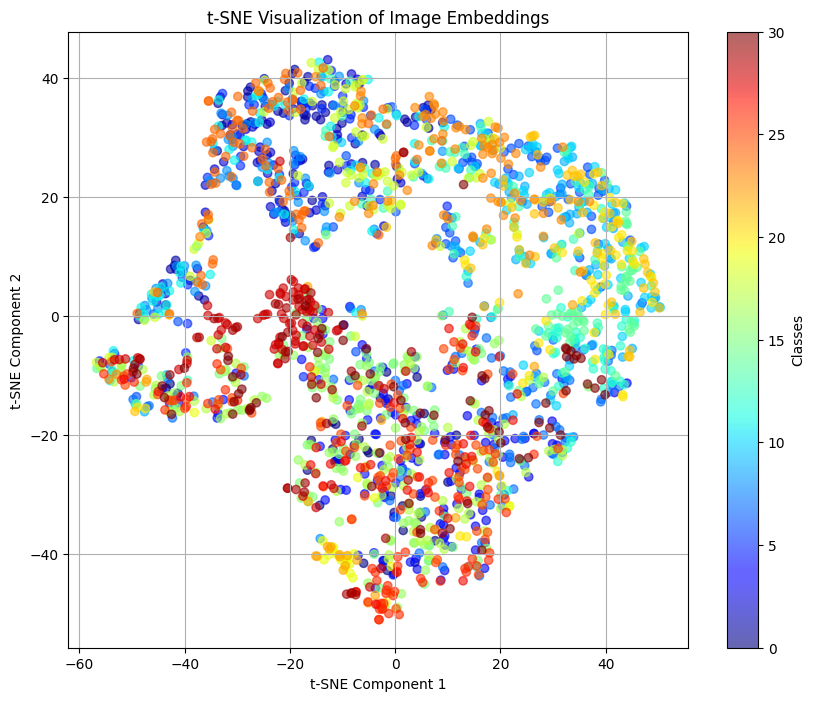

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Function to generate embeddings for a dataset
def generate_embeddings(images, model):
    embeddings = model.predict(images)
    return embeddings

# Generate embeddings for training images
train_embeddings = generate_embeddings(train_x, embedding_model)

# Use t-SNE to reduce dimensionality
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(train_embeddings)

# Plotting the t-SNE results
def plot_tsne(embeddings, labels):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='jet', alpha=0.6)
    plt.colorbar(scatter, label='Classes')
    plt.title('t-SNE Visualization of Image Embeddings')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid(True)
    plt.show()

# Plot the t-SNE results with labels
plot_tsne(embeddings_2d, train_y)


In [ ]:
known_images_dir = 'D:/DS_project/Jear_project/Original_Images/Original_Images'  

In [54]:
# Load the entire model
simese_model = tf.keras.models.load_model('full_model.h5', custom_objects={'TripletLossLayer': TripletLossLayer})


In [55]:
import os
import numpy as np
import pickle
import tensorflow as tf

# Function to preprocess a single image
def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return img_array

# Function to create an embedding model from the Siamese model
def create_embedding_model(siamese_model):
    # Access the 'model' layer, which is likely the base feature extractor (MobileNetV2 in your case)
    base_model = siamese_model.get_layer('model')  # Get the layer named 'model' inside your composite model
    embedding_model = tf.keras.Model(inputs=base_model.input, outputs=base_model.output)
    return embedding_model

# Create the embedding model from the trained siamese model
embedding_model = create_embedding_model(simese_model)

# Function to register a person
def register_person(image_paths, name, model, registered_dir='registered'):
    embeddings = []

    # Process each image and get its embedding
    for image_path in image_paths:
        image = preprocess_image(image_path)
        embedding = model.predict(image)[0]  # Generate embedding for a single image
        embeddings.append(embedding)

    # Compute the average embedding if multiple images were provided
    average_embedding = np.mean(embeddings, axis=0)
    
    # Save the embedding and label
    if not os.path.exists(registered_dir):
        os.makedirs(registered_dir)
    
    # Save the average embedding and name using pickle
    with open(os.path.join(registered_dir, f'{name}_embedding.pkl'), 'wb') as f:
        pickle.dump((average_embedding, name), f)

def register_multiple_people(people_data, model, registered_dir='registered'):
    for name, image_paths in people_data.items():
        print(f"Registering {name}...")
        register_person(image_paths, name, model, registered_dir)

# Example usage for registering



In [ ]:
register_person("D:/DS_project/Jear_project/Original_Images/Original_Images/Elizabeth Olsen/Elizabeth Olsen_0.jpg", 'olsen', embedding_model)

In [56]:
people_data = {
    'olsen': [
        "D:/DS_project/Jear_project/Original_Images/Original_Images/Elizabeth Olsen/Elizabeth Olsen_0.jpg",
        "D:/DS_project/Jear_project/Original_Images/Original_Images/Elizabeth Olsen/Elizabeth Olsen_1.jpg"
    ],
    'Brad': [
        "D:/DS_project/Jear_project/Original_Images/Original_Images/Brad Pitt/Brad Pitt_0.jpg",
        "D:/DS_project/Jear_project/Original_Images/Original_Images/Brad Pitt/Brad Pitt_1.jpg"
    ],
    'Dwayne': [
        "D:/DS_project/Jear_project/Original_Images/Original_Images/Dwayne Johnson/Dwayne Johnson_0.jpg",
        "D:/DS_project/Jear_project/Original_Images/Original_Images/Dwayne Johnson/Dwayne Johnson_1.jpg"
    ]
}

# Call the function to register all people in `people_data`
register_multiple_people(people_data, embedding_model)

Registering olsen...
1/1 [==============================] - 0s 19ms/step
Registering Brad...
1/1 [==============================] - 0s 17ms/step
Registering Dwayne...
1/1 [==============================] - 0s 18ms/step


In [68]:
import os
import numpy as np
import pickle
import tensorflow as tf

# Function to preprocess a single image
def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return img_array

# Function to create an embedding model from the Siamese model
def create_embedding_model(siamese_model):
    # Access the 'model' layer, which is likely the base feature extractor (MobileNetV2 in your case)
    base_model = siamese_model.get_layer('model')  # Get the layer named 'model' inside your composite model
    embedding_model = tf.keras.Model(inputs=base_model.input, outputs=base_model.output)
    return embedding_model

# Load registered embeddings from the folder
def load_registered_embeddings(registered_dir='registered'):
    registered_embeddings = []
    registered_labels = []
    
    for file_name in os.listdir(registered_dir):
        if file_name.endswith('_embedding.pkl'):
            with open(os.path.join(registered_dir, file_name), 'rb') as f:
                embedding, label = pickle.load(f)
                registered_embeddings.append(embedding)
                registered_labels.append(label)
    
    return np.array(registered_embeddings), registered_labels

# Function to find the closest match
def find_closest_match(new_embedding, registered_embeddings, registered_labels, threshold=0.5):
    distances = [np.linalg.norm(new_embedding - emb) for emb in registered_embeddings]
    closest_index = np.argmin(distances)
    closest_distance = distances[closest_index]
    
    if closest_distance > threshold:
        return "Unknown", closest_distance
    else:
        return registered_labels[closest_index], closest_distance

# Function to test a new image
def test_image(image_path, model, threshold=1, registered_dir='registered'):
    new_image = preprocess_image(image_path)
    new_embedding = model.predict(new_image)[0]  # Generate embedding for the new image
    
    # Load registered embeddings
    registered_embeddings, registered_labels = load_registered_embeddings(registered_dir)
    
    # Find the closest match
    label, distance = find_closest_match(new_embedding, registered_embeddings, registered_labels, threshold)
    print(f'The closest match is: {label} with a distance of {distance}')

# Create the embedding model from the Siamese model
embedding_model = create_embedding_model(simese_model)

# Example usage for testing a new image
test_image("D:/DS_project/Jear_project/Test/image12.jpg", embedding_model)


1/1 [==============================] - 0s 430ms/step
The closest match is: Dwayne with a distance of 0.7856122255325317


In [64]:
import numpy as np
import cv2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from PIL import Image

def preprocess(image: np.array, new_size: int = 224) -> np.array:
    image = cv2.resize(image, (new_size, new_size))
    image = image.astype(float)
    image = preprocess_input(image)
    return np.array([image])
# Load your model here
# simese_model = tf.keras.models.load_model('model_checkpoint.h5')

# Assuming main_faces_vector is already populated
main_faces_vector = {
    "olsen": model.predict(preprocess(np.array(Image.open("D:/DS_project/Jear_project/Original_Images/Original_Images/Elizabeth Olsen/Elizabeth Olsen_0.jpg")))),
    "henry": model.predict(preprocess(np.array(Image.open("D:/DS_project/Jear_project/Original_Images/Original_Images/Henry Cavill/Henry Cavill_0.jpg")))),
    "brad": model.predict(preprocess(np.array(Image.open("D:/DS_project/Jear_project/Original_Images/Original_Images/Brad Pitt/Brad Pitt_0.jpg")))),
    "brad": model.predict(preprocess(np.array(Image.open("D:/DS_project/Jear_project/Original_Images/Original_Images/Brad Pitt/Brad Pitt_3.jpg")))),
    "brad": model.predict(preprocess(np.array(Image.open("D:/DS_project/Jear_project/Original_Images/Original_Images/Brad Pitt/Brad Pitt_10.jpg")))),
    "brad": model.predict(preprocess(np.array(Image.open("D:/DS_project/Jear_project/Original_Images/Original_Images/Brad Pitt/Brad Pitt_15.jpg")))),
    "brad": model.predict(preprocess(np.array(Image.open("D:/DS_project/Jear_project/Original_Images/Original_Images/Brad Pitt/Brad Pitt_22.jpg")))),
    "the rock": model.predict(preprocess(np.array(Image.open("D:/DS_project/Jear_project/Original_Images/Original_Images/Dwayne Johnson/Dwayne Johnson_22.jpg")))),
    "the rock": model.predict(preprocess(np.array(Image.open("D:/DS_project/Jear_project/Original_Images/Original_Images/Dwayne Johnson/Dwayne Johnson_39.jpg")))),
    "the rock": model.predict(preprocess(np.array(Image.open("D:/DS_project/Jear_project/Original_Images/Original_Images/Dwayne Johnson/Dwayne Johnson_20.jpg"))))
    # Add more known faces as necessary
}


# Function to compute Euclidean distance
from numpy.linalg import norm

# Function to compute cosine similarity between two vectors
def eucledian_distance(feature1, feature2):
    return np.linalg.norm(feature1 - feature2)


def get_similarity_face_name(test_image_vector: np.array) -> str:
    nearest_face = None
    min_distance = None

    for face_name, face_vector in main_faces_vector.items():
        distance = eucledian_distance(face_vector, test_image_vector)
        if min_distance is None or distance < min_distance:
            min_distance = distance
            nearest_face = face_name
    return nearest_face
    

# Testing a new image
test_image_path = "D:/DS_project/Jear_project/Test/image13.jpg"  # Replace with the path to your test image
image = Image.open(test_image_path)
image = np.array(image)
image_input = preprocess(image=image)
face_vector = model.predict(image_input, verbose=0)  # Get the embedding for the test image
who = get_similarity_face_name(face_vector)  # Set your desired threshold here

print("The most similar face is:", who)


1/1 [==============================] - 0s 21ms/step
The most similar face is: brad
